## Setup

In [1]:
from google.colab import output
from google.colab import files
import os
import sys
import json
import random
import time
from tqdm import tqdm

project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import torch
from torch import optim
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image

import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import glob

In [2]:
# workers para dataloading
num_workers = 0
# samples por batch
batch_size = 64
# se ocupará este porcentaje para generar set de validación
valid_size = 0.2

# convertir data a vector torch normalizado
print('==> Preparando data..')
#Usar data augmentation por scores que he visto en distintos exp
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#No es necesario hacer augmentation en test
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# define sets de entrenamiento y test
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)

# Obtner los índices de los datos que se ocuparán para el set de validación
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Con esto se obtienen los batches de entrenamiento y validación
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparar data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# clases de img
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

==> Preparando data..


100%|██████████| 170M/170M [00:04<00:00, 40.9MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
def count_classes(loader, classes):
    class_counts = [0] * len(classes)
    for _, targets in loader:
        for label in targets:
            class_counts[label.item()] += 1
    return class_counts

# Count classes in train, valid, and test loaders
train_class_counts = count_classes(train_loader, classes)
valid_class_counts = count_classes(valid_loader, classes)
test_class_counts = count_classes(test_loader, classes)

# Display results
print("Train Loader Class Counts:")
for idx, count in enumerate(train_class_counts):
    print(f"{classes[idx]}: {count}")

print("\nValid Loader Class Counts:")
for idx, count in enumerate(valid_class_counts):
    print(f"{classes[idx]}: {count}")

print("\nTest Loader Class Counts:")
for idx, count in enumerate(test_class_counts):
    print(f"{classes[idx]}: {count}")


Train Loader Class Counts:
airplane: 3972
automobile: 4005
bird: 4043
cat: 4020
deer: 4025
dog: 3994
frog: 3980
horse: 3993
ship: 3959
truck: 4009

Valid Loader Class Counts:
airplane: 1028
automobile: 995
bird: 957
cat: 980
deer: 975
dog: 1006
frog: 1020
horse: 1007
ship: 1041
truck: 991

Test Loader Class Counts:
airplane: 1000
automobile: 1000
bird: 1000
cat: 1000
deer: 1000
dog: 1000
frog: 1000
horse: 1000
ship: 1000
truck: 1000


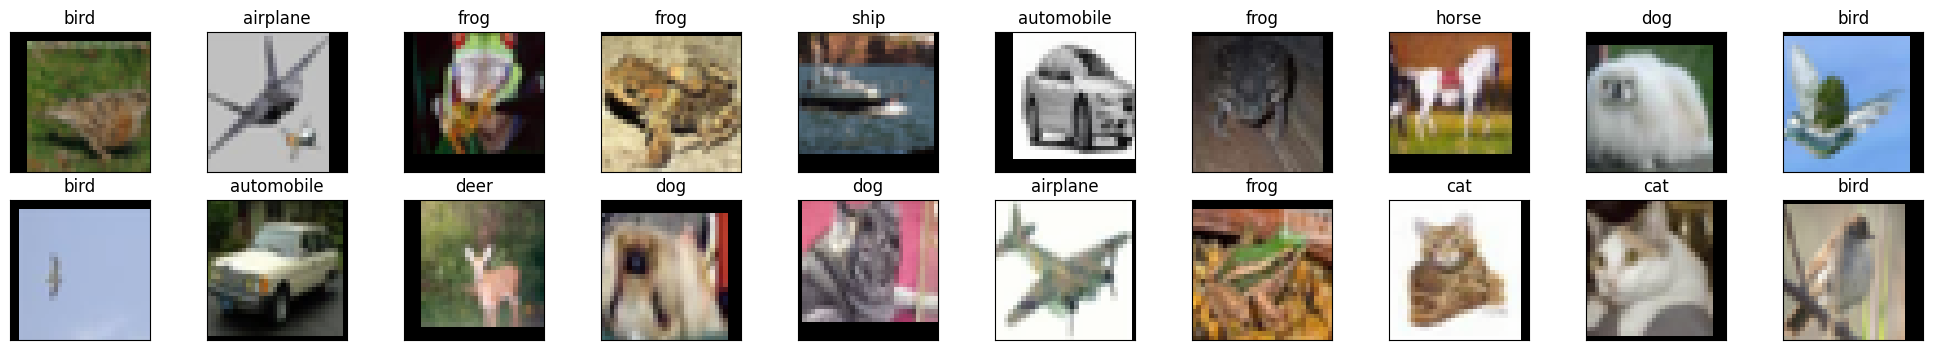

In [ ]:
#@title Display opcional
%matplotlib inline

# denormalizar y display
def imshow(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    # sacar la normalizacion con la operacion inversa
    img = img * std[:, None, None] + mean[:, None, None]  # aplicar denorm por canal
    img = np.clip(img, 0, 1)  # clipear valores
    plt.imshow(np.transpose(img, (1, 2, 0)))  # cambiar a formato de img

# sacar un batch de img
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convertir a np

# plit img y labels
fig = plt.figure(figsize=(25, 4))
# display 20 imgs
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])


## Attack

In [3]:
def denorm(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(batch.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(batch.device)
    return batch * std + mean

def renorm(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(batch.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(batch.device)
    return (batch - mean) / std

In [4]:
# FGSM attack clásico
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [5]:
# lfgsm attack
def lfgsm_attack(model, images, epsilon):

    images.requires_grad = True
    outputs = model(images)

    # least likely pred
    least_likely = outputs.min(1, keepdim=True)[1]

    # gradiente de ll
    loss = F.nll_loss(F.log_softmax(outputs, dim=1), least_likely.view(-1))
    model.zero_grad()
    loss.backward()

    # generar img adv
    data_grad = images.grad.data

    images = denorm(images)
    perturbed_images = images - epsilon * data_grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    perturbed_images = renorm(perturbed_images)

    return perturbed_images

In [6]:
def pgd_attack(model, images, labels, criterion, eps=0.1, alpha=0.01, n_iter=10):

    device = images.device
    perturbed_images = images.clone().detach().to(device)

    for _ in range(n_iter):
        perturbed_images.requires_grad = True
        # fw
        outputs = model(perturbed_images)
        loss = criterion(outputs, labels)
        # bw
        model.zero_grad()
        loss.backward()

        # calcular pert
        with torch.no_grad():
            grad_sign = perturbed_images.grad.sign()
            perturbed_images = perturbed_images + alpha * grad_sign
            # denorm
            denormalized_images = denorm(perturbed_images)
            # proyectar y clamp
            perturbation = torch.clamp(denormalized_images - images, min=-eps, max=eps)
            perturbed_images = torch.clamp(images + perturbation, min=0, max=1)
            # renormalizar
            perturbed_images = renorm(perturbed_images)

        # 0 grads
        perturbed_images.requires_grad = False

    return perturbed_images.detach()


In [7]:

# C&W L2 Attack
def cw_attack_L2(model, images, labels, c=1e-4, kappa=0, max_iter=200, lr=0.01):
    """
    Carlini & Wagner L2

    :param model: tar model
    :param images: input imgs
    :param labels: labels of input imgs
    :param c: param de confianza del ataque
    :param kappa: margen de minima confianza
    :param max_iter: numero maximo de iteraciones de optim
    :param lr: Lr de adam
    :return: adv_imgs
    """
    model.eval()
    device = images.device

    # pert: variable que requiere gradientes
    pert = torch.zeros_like(images, requires_grad=True, device=device)

    # optimizador para la perturbación
    optimizer = optim.Adam([pert], lr=lr)

    # definir la función de perdida única
    def f(x):
        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]), device=outputs.device)[labels]  # device
        i = (outputs * one_hot_labels).sum(dim=1)  # confianza de true class
        j = torch.max(outputs * (1 - one_hot_labels), dim=1).values  # confianza de max non true class
        return torch.clamp(j - i, min=-kappa)  # margen de confianza

    # loop de optimización
    for step in range(max_iter):
        # denormalizar y aplicar perturbación
        adv_images = denorm(images) + pert
        adv_images = torch.clamp(adv_images, 0, 1)  # clamp para mantener en [0,1]
        adv_images = renorm(adv_images)

        # cálculo loss
        l2_loss = torch.sum(pert ** 2)
        f_loss = c * torch.sum(f(adv_images))
        loss = l2_loss + f_loss

        # step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log de iteraciones
        if step % 100 == 0:
            print(f"Step [{step}/{max_iter}], Loss: {loss.item():.4f}")

    # finalmente generar la imagen adversaria
    adv_images = denorm(images) + pert
    adv_images = torch.clamp(adv_images, 0, 1)
    adv_images = renorm(adv_images)

    return adv_images


# insta test cw2
def test_cw_attack(model, test_loader, epsilon=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    test_loss = 0.0
    correct = 0
    criterion = nn.CrossEntropyLoss()

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # gen adv
        adv_images = cw_attack_L2(model, images, labels)

        # eval en adv
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Accuracy: {100 * correct / len(test_loader.dataset):.2f}%")


In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(pretrained=True)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 10)  # output a 10
# model = model.to(device)

# model.eval()

# # fn test de arriba
# test_cw_attack(model, test_loader)

## Defense



El tercer método (entrenamiento adversario) está incluido en la sección de entrenamiento.

In [ ]:
from PIL import Image
import io

def apply_jpeg_compression(tensor, quality=75):
    """
    :param tensor: tensor con batch dimension (B, C, H, W)
    :param quality: calidad, de 1 a 100
    :return: tensor comprimido
    """
    compressed_images = []
    for img in tensor:
        # tensor a pil img
        pil_image = transforms.ToPILImage()(img.cpu())

        # guardar a bufer con compresion jpeg
        buffer = io.BytesIO()
        pil_image.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)

        # recargar como imagen pil and y volver a tensor
        compressed_image = Image.open(buffer)
        compressed_images.append(transforms.ToTensor()(compressed_image))

    # devolver al stack
    return torch.stack(compressed_images).to(tensor.device)

In [ ]:
#@title Métodos ensamble

# clase ensamble
class EnsembleDefense:
    def __init__(self, models):
        """
        iniciar con lista de modelos pre entrenados
        :param models: lista de modelos
        """
        self.models = models
        for model in self.models:
            model.eval()

    def predict(self, x):
        """
        :param x: tensor in
        :return: logits promediados de todos los modelos
        """
        logits = [model(x) for model in self.models]
        ensemble_logits = torch.mean(torch.stack(logits), dim=0)
        return ensemble_logits

def load_ensemble_models():
    """
    cargar modelos pre entrenados
    :return: lista de modelos para ensamble
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load  red 1
    vgg_normal = models.vgg11(pretrained=True)
    num_features = vgg_normal.classifier[-1].in_features
    vgg_normal.classifier[-1] = torch.nn.Linear(num_features, 10)
    vgg_normal.to(device)

    # load red 2
    mobilenet_normal = models.mobilenet_v3_large(pretrained=True)
    num_features = mobilenet_normal.classifier[-1].in_features
    mobilenet_normal.classifier[-1] = torch.nn.Linear(num_features, 10)
    mobilenet_normal.to(device)

    # load red 3
    resnet_normal = models.resnet18(pretrained=True)
    num_features = resnet_normal.fc.in_features
    resnet_normal.fc = torch.nn.Linear(num_features, 10)
    resnet_normal.to(device)

    return [vgg_normal, mobilenet_normal, resnet_normal]


# test ensamble
def test_ensemble_defense(ensemble, test_loader, epsilon=0.1, attack_model='fgsm'):
    """
    test
    :param ensemble: instancia de ensembledef
    :param test_loader: dataloader deseado
    :param epsilon: epsilon
    :param attack_model: tipo de ataque ('fgsm' or 'pgd')
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # gen adv
        if attack_model == 'fgsm':
            data.requires_grad = True
            outputs = ensemble.models[0](data)  # usar modelo 1 para grads
            loss = F.cross_entropy(outputs, target)
            loss.backward()
            data_grad = data.grad.data
            data = fgsm_attack(data, epsilon, data_grad)

        elif attack_model == 'pgd':
            data = pgd_attack(ensemble.models[0], data, target, F.cross_entropy, eps=epsilon, alpha=0.01, n_iter=10)

        # prediccion de ensamble
        outputs = ensemble.predict(data)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

    accuracy = 100 * correct / total
    print(f'Ensemble Defense Accuracy under {attack_model} attack with epsilon={epsilon}: {accuracy:.2f}%')

# el código de load_ensamble se debe cambiar cada vez que se quiera probar una nueva combinación

# load y creear ensamble
models = load_ensemble_models()
ensemble = EnsembleDefense(models)

# test
epsilon = 0.1
test_ensemble_defense(ensemble, test_loader, epsilon=epsilon, attack_model='fgsm')
test_ensemble_defense(ensemble, test_loader, epsilon=epsilon, attack_model='pgd')

## Training Regime

In [ ]:
#@title Def training
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        self.epochs_with_no_improvement += 1
        if val_loss <= self.best_loss:
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

def train_model(
    model,
    train_loader,
    val_loader,
    max_epochs,
    criterion,
    optimizer,
    early_stopping_tolerance=15,
    use_gpu=False
):
    if use_gpu:
        model.cuda()
    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)
    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

            optimizer.zero_grad()
            y_predicted = model(x_batch)
            loss = criterion(y_predicted, y_batch)
            loss.backward()
            optimizer.step()
            cumulative_train_loss += loss.item()
            _, preds = torch.max(y_predicted, 1)
            cumulative_train_corrects += torch.sum(preds == y_batch)

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects.double() / len(train_loader.sampler)

        model.eval()
        cumulative_val_loss = 0
        cumulative_val_corrects = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                if use_gpu:
                    x_val, y_val = x_val.cuda(), y_val.cuda()
                y_predicted = model(x_val)
                loss = criterion(y_predicted, y_val)
                cumulative_val_loss += loss.item()
                _, preds = torch.max(y_predicted, 1)
                cumulative_val_corrects += torch.sum(preds == y_val)

        val_loss = cumulative_val_loss / len(val_loader)
        val_acc = cumulative_val_corrects.double() / len(val_loader.sampler)
        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{max_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print(f"Total training time: {time.perf_counter() - t0:.4f} seconds")
    model.cpu()
    return curves

def robust_training(
    model,
    train_loader,
    val_loader,
    max_epochs,
    criterion,
    optimizer,
    early_stopping_tolerance=15,
    use_gpu=False,
    attack='fgsm'
):
    if use_gpu:
        model.cuda()
    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)
    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()

    for epoch in range(max_epochs):
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

            if attack == 'fgsm':
                x_batch.requires_grad = True
                y_predicted = model(x_batch)
                loss = criterion(y_predicted, y_batch)
                model.zero_grad()
                loss.backward()
                data_grad = x_batch.grad.data

                x_batch = denorm(x_batch, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
                x_batch = fgsm_attack(x_batch, 0.1, data_grad)
                x_batch = renorm(x_batch, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

            elif attack == 'pgd':
                # aplica pgd # tiene nrom y denorm propia
                x_batch = pgd_attack(model, x_batch, y_batch, criterion, n_iter=10, eps=0.1, alpha=0.01)

            elif attack == 'cw':
                # aplica c&w # tiene nrom y denorm propia
                x_batch = cw_attack(model, x_batch, y_batch, c=1e-4, kappa=0, max_iter=100, lr=0.01)

            elif attack == 'lfgsm':
                # aplica lfgsm # tiene nrom y denorm propia
                x_batch = lfgsm_attack(model, x_batch, 0.1)


            optimizer.zero_grad()
            y_predicted = model(x_batch)
            loss = criterion(y_predicted, y_batch)
            loss.backward()
            optimizer.step()


            cumulative_train_loss += loss.item()
            _, preds = torch.max(y_predicted, 1)
            cumulative_train_corrects += torch.sum(preds == y_batch)

        train_loss = cumulative_train_loss / len(train_loader)
        train_acc = cumulative_train_corrects.double() / len(train_loader.sampler)

        model.eval()
        cumulative_val_loss = 0
        cumulative_val_corrects = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                if use_gpu:
                    x_val, y_val = x_val.cuda(), y_val.cuda()
                #se puede incluir ataque aca de querer, pero gasta muchos recursos

                y_predicted = model(x_val)
                loss = criterion(y_predicted, y_val)
                cumulative_val_loss += loss.item()
                _, preds = torch.max(y_predicted, 1)
                cumulative_val_corrects += torch.sum(preds == y_val)

        val_loss = cumulative_val_loss / len(val_loader)
        val_acc = cumulative_val_corrects.double() / len(val_loader.sampler)
        curves["train_acc"].append(train_acc.item())
        curves["val_acc"].append(val_acc.item())
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{max_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print(f"Total training time: {time.perf_counter() - t0:.4f} seconds")
    model.cpu()
    return curves

In [ ]:
def prepare_model(model_name, num_classes=10):
    # load model
    model = getattr(models, model_name)(pretrained=False)

    # ajustar tags number
    if "resnet" in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif "vgg" in model_name:
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, num_classes)
    elif "mobilenet" in model_name:
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, num_classes)
    elif "densenet" in model_name:
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
    elif "efficientnet" in model_name:
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif "squeezenet" in model_name:
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes
    elif "shufflenet" in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

    return model

def train_and_save_model(
    model_name, train_loader, val_loader, epochs, lr,
    use_gpu, robust=False, attack="fgsm"
):
    # prep modelo
    model = prepare_model(model_name)
    if use_gpu:
        model.cuda()

    # criterio y optim
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001
    )

    # escoger entrenamiento
    if robust:
        curves = robust_training(
            model, train_loader, val_loader, epochs, criterion, optimizer,
            use_gpu=use_gpu, attack=attack
        )
    else:
        curves = train_model(
            model, train_loader, val_loader, epochs, criterion, optimizer,
            use_gpu=use_gpu
        )

    # guardar
    save_path = f"{model_name}_{attack if robust else 'normal'}_weights.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model {model_name} saved to {save_path}")

    return curves

In [ ]:
use_gpu = torch.cuda.is_available()
epochs = 15
lr = 0.01
batch_size = 32

In [ ]:
curves_resnet18_robust1 = train_and_save_model(
    "resnet18", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="fgsm"
)
curves_resnet18_robust2 = train_and_save_model(
    "resnet18", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="lfgsm"
)
curves_resnet18_robust3 = train_and_save_model(
    "resnet18", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="pgd"
)

In [ ]:
curves_vgg11_robust1 = train_and_save_model(
    "vgg11", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="fgsm"
)
curves_vgg11_robust2 = train_and_save_model(
    "vgg11", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="lfgsm"
)
curves_vgg11_robust3 = train_and_save_model(
    "vgg11", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="pgd"
)

In [ ]:
curves_mobilenet_v2_robust1 = train_and_save_model(
    "mobilenet_v2", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="fgsm"
)
curves_mobilenet_v2_robust2 = train_and_save_model(
    "mobilenet_v2", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="lfgsm"
)
curves_mobilenet_v2_robust3 = train_and_save_model(
    "mobilenet_v2", train_loader, valid_loader, epochs, lr, use_gpu, robust=True, attack="pgd"
)

## Test functions

In [9]:
def test_model(attacker_model, target_model, test_loader, epsilon):
    attacker_model.eval()
    target_model.eval()
    test_loss = 0.0
    class_correct = [0] * 10
    class_total = [0] * 10
    batch_idx = 0

    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()


        # target realiza pred
        output = target_model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = correct_tensor.cpu().tolist()

        # usar el batch size
        for i in range(len(target)):
            label = target.data[i].item()
            class_correct[label] += correct[i]
            class_total[label] += 1

        batch_idx+=1
        print(f"Batch: {batch_idx+1}")
        print(f"Class Correct: {class_correct}")
        print(f"Class Total: {class_total}")

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.6f}\n')

    for i in range(10):
        if class_total[i] > 0:
            print(f'Test Accuracy of {classes[i]:5s}: {100 * class_correct[i] / class_total[i]:2.0f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Test Accuracy of {classes[i]:5s}: N/A (no training examples)')

    overall_acc = 100. * np.sum(class_correct) / np.sum(class_total)
    print(f'\nTest Accuracy (Overall): {overall_acc:2.0f}% ({np.sum(class_correct)}/{np.sum(class_total)})')



In [14]:
def test_model_attack(attacker_model, target_model, test_loader, attack_model='fgsm', epsilon=0.1):

    attacker_model.eval()
    target_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    class_correct = [0] * 10
    class_total = [0] * 10
    batch_idx = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # select ataque
        if attack_model == 'fgsm':
            data.requires_grad = True
            output = attacker_model(data)
            loss = criterion(output, target)
            attacker_model.zero_grad()
            loss.backward()
            data_grad = data.grad.data

            # aplica fgsm
            data = denorm(data, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
            perturbed_data = renorm(perturbed_data, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

        elif attack_model == 'pgd':
            # aplica pgd # tiene norm y denorm propia
            perturbed_data = pgd_attack(attacker_model, data, target, criterion, n_iter=10, eps=epsilon, alpha=0.01)

        elif attack_model == 'cw':
            # aplica c&w # tiene norm y denorm propia
            perturbed_data = cw_attack_L2(attacker_model, data, target, c=1e-4, kappa=0, max_iter=100, lr=0.01)

        elif attack_model == 'lfgsm':
            # aplica lfgsm # tiene norm y denorm propia
            perturbed_data = lfgsm_attack(attacker_model, data, epsilon)

        else:
            raise ValueError(f"Unknown attack model: {attack_model}")

        # test target
        output = target_model(perturbed_data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = correct_tensor.cpu().tolist()

        for i in range(len(target)):
            label = target.data[i].item()
            class_correct[label] += correct[i]
            class_total[label] += 1

        batch_idx += 1
        # uncomment if debug
        #print(f"Batch: {batch_idx}/{len(test_loader)}")
        #print(f"Class Correct: {class_correct}")
        #print(f"Class Total: {class_total}")

    # Calculate average test loss
    test_loss /= len(test_loader.dataset)
    print(f'\nTest Loss: {test_loss:.6f}\n')

    # Calculate accuracy per class and overall
    for i in range(10):
        if class_total[i] > 0:
            print(f'Test Accuracy of {classes[i]:5s}: {100 * class_correct[i] / class_total[i]:2.0f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'Test Accuracy of {classes[i]:5s}: N/A (no training examples)')

    overall_acc = 100. * np.sum(class_correct) / np.sum(class_total)
    print(f'\nTest Accuracy (Overall): {overall_acc:2.0f}% ({np.sum(class_correct)}/{np.sum(class_total)})')


## Load and Run

### Load models

In [11]:
from torchvision import models

# 10 clases
num_classes = 10

# lista de modelos
model_names = [
    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
    "mobilenet_v2", "mobilenet_v3_small", "mobilenet_v3_large",
    "vgg11", "vgg13", "vgg16", "vgg19",
    "densenet121", "densenet161", "densenet169", "densenet201",
    "efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3",
    "efficientnet_b4", "efficientnet_b5", "efficientnet_b6", "efficientnet_b7",
    "squeezenet1_0", "squeezenet1_1",
    "shufflenet_v2_x0_5", "shufflenet_v2_x1_0", "shufflenet_v2_x1_5", "shufflenet_v2_x2_0"
]

# diccionario para guardar los modelos
modified_models = {}

for model_name in model_names:
    # load pretrained
    try:
        model = getattr(models, model_name)(pretrained=False)
    except AttributeError:
        print(f" {model_name} no esta en torch.")
        continue

    # ultima capa tiene 10 features
    if "resnet" in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif "mobilenet" in model_name:
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, num_classes)
    elif "vgg" in model_name:
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, num_classes)
    elif "densenet" in model_name:
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
    elif "efficientnet" in model_name:
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif "squeezenet" in model_name:
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model.num_classes = num_classes
    elif "shufflenet" in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

    # guardar el modelo en el diccionario
    modified_models[model_name] = model

# print
#for name, model in modified_models.items():
#    print(f"Modified {name}:\n", model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Para ocupar estos modelos se ocupa el diccionario 'modified_models'.

### Testing models

Los parámetros de los ataques de test_model_attack se deben cambiar directamente en la función mencionada y se debe ejecutar la celda de nuevo. Así, el resto de los ataques se corren con los valores estándar.  

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_attack(modified_models['resnet18'].to(device), modified_models['resnet18'].to(device), test_loader, attack_model='cw', epsilon=0.1)

Step [0/100], Loss: 0.0050
Step [0/100], Loss: 0.0040
Step [0/100], Loss: 0.0052
Step [0/100], Loss: 0.0055
Step [0/100], Loss: 0.0045
Step [0/100], Loss: 0.0049
Step [0/100], Loss: 0.0046
Step [0/100], Loss: 0.0053
Step [0/100], Loss: 0.0050
Step [0/100], Loss: 0.0049
Step [0/100], Loss: 0.0044
Step [0/100], Loss: 0.0045
Step [0/100], Loss: 0.0044
Step [0/100], Loss: 0.0045
Step [0/100], Loss: 0.0044
Step [0/100], Loss: 0.0047
Step [0/100], Loss: 0.0043
Step [0/100], Loss: 0.0042
Step [0/100], Loss: 0.0046
Step [0/100], Loss: 0.0048
Step [0/100], Loss: 0.0057
Step [0/100], Loss: 0.0046
Step [0/100], Loss: 0.0047
Step [0/100], Loss: 0.0047
Step [0/100], Loss: 0.0047
Step [0/100], Loss: 0.0053
Step [0/100], Loss: 0.0051
Step [0/100], Loss: 0.0044
Step [0/100], Loss: 0.0057
Step [0/100], Loss: 0.0049
Step [0/100], Loss: 0.0042
Step [0/100], Loss: 0.0047
Step [0/100], Loss: 0.0045
Step [0/100], Loss: 0.0049
Step [0/100], Loss: 0.0046
Step [0/100], Loss: 0.0045
Step [0/100], Loss: 0.0045
S

In [ ]:
ResNet18.load_state_dict(torch.load('resnet18_weights.pth'))
ResNet34.load_state_dict(torch.load('resnet34_weights.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ResNet18.to(device)
ResNet34.to(device)

# Correr test
epsilon = 0.2
test_model_attack(ResNet18, ResNet34, test_loader, epsilon)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cargar modelo
resnet18 = models.resnet18(pretrained=False)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)  # ajustar a 10 out
resnet18.load_state_dict(torch.load('resnet18_fgsm_weights.pth'))  # cargar pesos
resnet18.to(device)  # Move model to the device



# test ante ataques
epsilon = 0.1
test_model_attack(resnet18, resnet18, test_loader, attack_model='fgsm', epsilon=epsilon)
test_model_attack(resnet18, resnet18, test_loader, attack_model='lfgsm', epsilon=epsilon)
test_model_attack(resnet18, resnet18, test_loader, attack_model='pgd', epsilon=epsilon)

<ipython-input-23-709ff0e90b68>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load('resnet18_fgsm_weights.pth'))  # Load weights



Test Loss: 2.305240

Test Accuracy of airplane: 53% (530/1000)
Test Accuracy of automobile: 34% (344/1000)
Test Accuracy of bird : 41% (407/1000)
Test Accuracy of cat  : 18% (185/1000)
Test Accuracy of deer : 32% (325/1000)
Test Accuracy of dog  : 13% (129/1000)
Test Accuracy of frog : 16% (164/1000)
Test Accuracy of horse: 28% (280/1000)
Test Accuracy of ship : 53% (529/1000)
Test Accuracy of truck: 20% (202/1000)

Test Accuracy (Overall): 31% (3095/10000)

Test Loss: 1.565245

Test Accuracy of airplane: 69% (690/1000)
Test Accuracy of automobile: 67% (668/1000)
Test Accuracy of bird : 44% (438/1000)
Test Accuracy of cat  : 28% (280/1000)
Test Accuracy of deer : 26% (257/1000)
Test Accuracy of dog  : 20% (196/1000)
Test Accuracy of frog : 45% (446/1000)
Test Accuracy of horse: 44% (441/1000)
Test Accuracy of ship : 68% (680/1000)
Test Accuracy of truck: 56% (555/1000)

Test Accuracy (Overall): 47% (4651/10000)

Test Loss: 2.133172

Test Accuracy of airplane: 69% (689/1000)
Test Accur

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = models.resnet18(pretrained=False)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 10)
resnet18.load_state_dict(torch.load('resnet18_pgd_weights.pth'))
resnet18.to(device)

epsilon = 0.1
test_model_attack(resnet18, resnet18, test_loader, attack_model='fgsm', epsilon=epsilon)
test_model_attack(resnet18, resnet18, test_loader, attack_model='lfgsm', epsilon=epsilon)
test_model_attack(resnet18, resnet18, test_loader, attack_model='pgd', epsilon=epsilon)

<ipython-input-24-36c7d5ee8929>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load('resnet18_pgd_weights.pth'))  # Load weights



Test Loss: 5.946116

Test Accuracy of airplane: 10% (98/1000)
Test Accuracy of automobile:  0% (0/1000)
Test Accuracy of bird :  3% (30/1000)
Test Accuracy of cat  :  0% (1/1000)
Test Accuracy of deer :  1% (9/1000)
Test Accuracy of dog  :  0% (5/1000)
Test Accuracy of frog :  0% (2/1000)
Test Accuracy of horse:  0% (0/1000)
Test Accuracy of ship :  0% (4/1000)
Test Accuracy of truck:  0% (0/1000)

Test Accuracy (Overall):  1% (149/10000)

Test Loss: 2.635669

Test Accuracy of airplane: 46% (462/1000)
Test Accuracy of automobile: 18% (179/1000)
Test Accuracy of bird : 44% (441/1000)
Test Accuracy of cat  : 12% (118/1000)
Test Accuracy of deer : 14% (142/1000)
Test Accuracy of dog  : 11% (111/1000)
Test Accuracy of frog : 28% (285/1000)
Test Accuracy of horse:  2% (25/1000)
Test Accuracy of ship : 30% (300/1000)
Test Accuracy of truck: 24% (237/1000)

Test Accuracy (Overall): 23% (2300/10000)

Test Loss: 1.025366

Test Accuracy of airplane: 76% (756/1000)
Test Accuracy of automobile: 7

In [ ]:
vgg11 = models.vgg11(pretrained=False)
vgg11.classifier[6] = nn.Linear(vgg11.classifier[6].in_features, 10)

# Load weights
vgg11.load_state_dict(torch.load('vgg11_fgsm_weights.pth'))
vgg11.to(device)

epsilon = 0.1
test_model_attack(vgg11, vgg11, test_loader, attack_model='fgsm', epsilon=epsilon)
test_model_attack(vgg11, vgg11, test_loader, attack_model='lfgsm', epsilon=epsilon)
test_model_attack(vgg11, vgg11, test_loader, attack_model='pgd', epsilon=epsilon)

<ipython-input-25-928776973711>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg11.load_state_dict(torch.load('vgg11_fgsm_weights.pth'))  # Replace with the correct path


Test Loss: 0.738731

Test Accuracy of airplane: 79% (790/1000)
Test Accuracy of automobile: 81% (807/1000)
Test Accuracy of bird : 68% (676/1000)
Test Accuracy of cat  : 67% (669/1000)
Test Accuracy of deer : 64% (645/1000)
Test Accuracy of dog  : 63% (630/1000)
Test Accuracy of frog : 86% (864/1000)
Test Accuracy of horse: 86% (862/1000)
Test Accuracy of ship : 82% (815/1000)
Test Accuracy of truck: 80% (801/1000)

Test Accuracy (Overall): 76% (7559/10000)

Test Loss: 1.243371

Test Accuracy of airplane: 64% (637/1000)
Test Accuracy of automobile: 79% (787/1000)
Test Accuracy of bird : 50% (504/1000)
Test Accuracy of cat  : 55% (547/1000)
Test Accuracy of deer : 40% (404/1000)
Test Accuracy of dog  : 51% (514/1000)
Test Accuracy of frog : 68% (679/1000)
Test Accuracy of horse: 77% (766/1000)
Test Accuracy of ship : 60% (598/1000)
Test Accuracy of truck: 71% (706/1000)

Test Accuracy (Overall): 61% (6142/10000)

Test Loss: 2.135187

Test Accuracy of airplane: 49% (486/1000)
Test Accur

In [ ]:
vgg11 = models.vgg11(pretrained=False)
vgg11.classifier[6] = nn.Linear(vgg11.classifier[6].in_features, 10)  # ajustar outputs

# cargar pesos
vgg11.load_state_dict(torch.load('vgg11_pgd_weights.pth'))
vgg11.to(device)

# test
epsilon = 0.1
test_model_attack(vgg11, vgg11, test_loader, attack_model='fgsm', epsilon=epsilon)
test_model_attack(vgg11, vgg11, test_loader, attack_model='lfgsm', epsilon=epsilon)
test_model_attack(vgg11, vgg11, test_loader, attack_model='pgd', epsilon=epsilon)

<ipython-input-26-ec48f231f37e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg11.load_state_dict(torch.load('vgg11_pgd_weights.pth'))  # Replace with the correct path 


Test Loss: 5.157379

Test Accuracy of airplane:  1% (13/1000)
Test Accuracy of automobile:  0% (0/1000)
Test Accuracy of bird :  4% (38/1000)
Test Accuracy of cat  :  3% (34/1000)
Test Accuracy of deer :  7% (68/1000)
Test Accuracy of dog  :  0% (0/1000)
Test Accuracy of frog :  2% (25/1000)
Test Accuracy of horse:  0% (0/1000)
Test Accuracy of ship :  5% (48/1000)
Test Accuracy of truck:  0% (0/1000)

Test Accuracy (Overall):  2% (226/10000)

Test Loss: 2.597569

Test Accuracy of airplane: 22% (223/1000)
Test Accuracy of automobile: 28% (284/1000)
Test Accuracy of bird : 25% (247/1000)
Test Accuracy of cat  : 33% (334/1000)
Test Accuracy of deer : 53% (529/1000)
Test Accuracy of dog  :  6% (65/1000)
Test Accuracy of frog : 50% (498/1000)
Test Accuracy of horse: 14% (137/1000)
Test Accuracy of ship : 23% (232/1000)
Test Accuracy of truck: 29% (293/1000)

Test Accuracy (Overall): 28% (2842/10000)

Test Loss: 0.961818

Test Accuracy of airplane: 68% (676/1000)
Test Accuracy of automobil

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
mobilenet_v2 = models.mobilenet_v2(pretrained=False)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, 10)  # 10 output

# Load weights
mobilenet_v2.load_state_dict(torch.load('mobilenet_v2_fgsm_weights.pth'))
mobilenet_v2.to(device)

# test
epsilon = 0.1
test_model_attack(mobilenet_v2, mobilenet_v2, test_loader, attack_model='fgsm', epsilon=epsilon)
test_model_attack(mobilenet_v2, mobilenet_v2, test_loader, attack_model='lfgsm', epsilon=epsilon)
test_model_attack(mobilenet_v2, mobilenet_v2, test_loader, attack_model='pgd', epsilon=epsilon)

<ipython-input-31-3a22546f24b8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet_v2.load_state_dict(torch.load('mobilenet_v2_fgsm_weights.pth'))  # Replace with th


Test Loss: 8.571265

Test Accuracy of airplane:  2% (16/1000)
Test Accuracy of automobile:  0% (3/1000)
Test Accuracy of bird :  2% (22/1000)
Test Accuracy of cat  :  1% (6/1000)
Test Accuracy of deer :  1% (8/1000)
Test Accuracy of dog  :  0% (5/1000)
Test Accuracy of frog :  0% (1/1000)
Test Accuracy of horse:  0% (3/1000)
Test Accuracy of ship :  5% (51/1000)
Test Accuracy of truck:  0% (0/1000)

Test Accuracy (Overall):  1% (115/10000)

Test Loss: 6.365258

Test Accuracy of airplane: 10% (102/1000)
Test Accuracy of automobile:  4% (39/1000)
Test Accuracy of bird :  5% (48/1000)
Test Accuracy of cat  :  4% (36/1000)
Test Accuracy of deer :  8% (75/1000)
Test Accuracy of dog  : 11% (113/1000)
Test Accuracy of frog : 10% (100/1000)
Test Accuracy of horse: 17% (171/1000)
Test Accuracy of ship : 11% (113/1000)
Test Accuracy of truck:  4% (43/1000)

Test Accuracy (Overall):  8% (840/10000)

Test Loss: 6.493430

Test Accuracy of airplane:  5% (54/1000)
Test Accuracy of automobile:  6% (5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
mobilenet_v2 = models.mobilenet_v2(pretrained=False)
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, 10)  #


mobilenet_v2.load_state_dict(torch.load('mobilenet_v2_pgd_weights.pth'))
mobilenet_v2.to(device)

# test
epsilon = 0.1
test_model_attack(mobilenet_v2, mobilenet_v2, test_loader, attack_model='fgsm', epsilon=epsilon)
test_model_attack(mobilenet_v2, mobilenet_v2, test_loader, attack_model='lfgsm', epsilon=epsilon)
test_model_attack(mobilenet_v2, mobilenet_v2, test_loader, attack_model='pgd', epsilon=epsilon)

<ipython-input-30-6f818a44848b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mobilenet_v2.load_state_dict(torch.load('mobilenet_v2_pgd_weights.pth'))  # Replace with the


Test Loss: 4.217290

Test Accuracy of airplane: 18% (179/1000)
Test Accuracy of automobile:  0% (0/1000)
Test Accuracy of bird :  6% (59/1000)
Test Accuracy of cat  :  0% (0/1000)
Test Accuracy of deer :  0% (4/1000)
Test Accuracy of dog  :  0% (3/1000)
Test Accuracy of frog :  0% (0/1000)
Test Accuracy of horse:  0% (0/1000)
Test Accuracy of ship :  0% (1/1000)
Test Accuracy of truck:  0% (0/1000)

Test Accuracy (Overall):  2% (246/10000)

Test Loss: 2.259793

Test Accuracy of airplane: 69% (688/1000)
Test Accuracy of automobile: 15% (153/1000)
Test Accuracy of bird : 47% (473/1000)
Test Accuracy of cat  :  8% (76/1000)
Test Accuracy of deer : 33% (334/1000)
Test Accuracy of dog  : 11% (110/1000)
Test Accuracy of frog : 20% (195/1000)
Test Accuracy of horse:  1% (12/1000)
Test Accuracy of ship : 33% (331/1000)
Test Accuracy of truck:  6% (65/1000)

Test Accuracy (Overall): 24% (2437/10000)

Test Loss: 1.396112

Test Accuracy of airplane: 60% (600/1000)
Test Accuracy of automobile: 71

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_models['resnet18'] = modified_models['resnet18'].to(device)
modified_models['resnet50'] = modified_models['resnet50'].to(device)

# test fgsm con compresion jpeg
test_model_attack(
    modified_models['resnet18'],
    modified_models['resnet18'],
    test_loader,
    attack_model='fgsm',
    epsilon=0.1,
    jpeg_quality=75
)

# test pgd con compresion jpeg
test_model_attack(
    modified_models['resnet50'],
    modified_models['resnet50'],
    test_loader,
    attack_model='pgd',
    epsilon=0.1,
    jpeg_quality=90
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_models['vgg11'] = modified_models['vgg11'].to(device)
modified_models['vgg16'] = modified_models['vgg16'].to(device)

#  ..
test_model_attack(
    modified_models['vgg11'],
    modified_models['vgg11'],
    test_loader,
    attack_model='fgsm',
    epsilon=0.1,
    jpeg_quality=75
)

# ..
test_model_attack(
    modified_models['vgg16'],
    modified_models['vgg16'],
    test_loader,
    attack_model='pgd',
    epsilon=0.1,
    jpeg_quality=90
)

## Quick visual

In [ ]:
#@title Ver ataques

def visualize_adversarial_attacks_with_symbols(attacker_model, image, label, criterion, epsilon=0.1):
    # mover label e img a device
    image, label = image.to(device), label.to(device)
    original_image = image.clone().detach()
    attacks = ['fgsm','lfgsm', 'pgd', 'cw']
    results = {}

    for attack_model in attacks:

        image_clone = original_image.clone().detach().requires_grad_(True)
        attacker_model.zero_grad()

        if attack_model == 'fgsm':
            output = attacker_model(image_clone)
            loss = criterion(output, label)
            loss.backward()
            data_grad = image_clone.grad.data


            denormed_image = denorm(image_clone)
            perturbed_image = fgsm_attack(denormed_image, epsilon, data_grad)
            perturbed_image = renorm(perturbed_image)

        elif attack_model == 'lfgsm':
            perturbed_image = lfgsm_attack(attacker_model, image_clone, epsilon)

        elif attack_model == 'pgd':
            perturbed_image = pgd_attack(attacker_model, image_clone, label, criterion, n_iter=10, eps=epsilon, alpha=0.01)

        elif attack_model == 'cw':
            perturbed_image = cw_attack_L2(attacker_model, image_clone, label, c=1e-4, kappa=0, max_iter=100, lr=0.01)



        else:
            raise ValueError(f"Unknown attack model: {attack_model}")

        # ruido y normalizar para ver
        noise = denorm(perturbed_image) - denorm(original_image)
        normalized_noise = (noise - noise.min()) / (noise.max() - noise.min())

        # guardar
        results[attack_model] = (denorm(original_image), normalized_noise, denorm(perturbed_image))


    fig, axes = plt.subplots(len(attacks), 5, figsize=(10, len(attacks) * 2))
    fig.suptitle("Visualización de ataque adversario", fontsize=16)

    for i, attack_model in enumerate(attacks):
        original, noise, adv_image = results[attack_model]

        # plot img og
        axes[i, 0].imshow(np.transpose(original.squeeze().cpu().detach().numpy(), (1, 2, 0)))
        axes[i, 0].set_title(f"Original ({attack_model})")
        axes[i, 0].axis('off')

        # agregar el +
        axes[i, 1].text(0.5, 0.5, '+', fontsize=20, ha='center', va='center', color='black')
        axes[i, 1].axis('off')

        # plot ruido
        axes[i, 2].imshow(np.transpose(noise.squeeze().cpu().detach().numpy(), (1, 2, 0)), cmap='gray')
        axes[i, 2].set_title(f"Noise ({attack_model})")
        axes[i, 2].axis('off')

        # agregar =
        axes[i, 3].text(0.5, 0.5, '=', fontsize=20, ha='center', va='center', color='black')
        axes[i, 3].axis('off')

        # plot adv
        axes[i, 4].imshow(np.transpose(adv_image.squeeze().cpu().detach().numpy(), (1, 2, 0)))
        axes[i, 4].set_title(f"Adversarial ({attack_model})")
        axes[i, 4].axis('off')

    plt.subplots_adjust(wspace=0.005, hspace=0.3)
    plt.show()


# escoger una img y label
dataiter = iter(test_loader)
images, labels = next(dataiter)
single_image, single_label = images[23:24], labels[23:24] # cambiar para ver otra img

# visualizar
visualize_adversarial_attacks_with_symbols(attacker_model=model, image=single_image, label=single_label, criterion=nn.CrossEntropyLoss(), epsilon=0.1)
